In [786]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

train_df = pd.read_csv("https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/train.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528451801&Signature=IkCgr5i2gzmKXSWUjv2JvZNmOebppNpa%2Fqbt6arGni3ncDk3yX9%2B6wss2c39Ex42Zj6xlvplgsk3m3HbJveZtD7wavSKwM2gu17UC1TGktgGHVtdYXhR%2Bsnjx8ObLAzr9ZmUFFqYNT3F3eY4Toyn9BgMq7vBo3rDU7sndn1ZGEGWWaitBy34kjYLCCBrGACxP%2BuJauVbHaEpuHA7cc2pFUB6w3qZLrzn7kcKWo5aBdZZ3I1e%2FbcMo738LxJirq1MLoxsUvTrgqexhHTOf01QBCR07R8M1zxVROxkIYMV0ByVG7qrQNpO1h%2Ff%2B6xzQZgubR7CwPHzw%2F6N1dXNOk48Ww%3D%3D")
test_df = pd.read_csv("https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/test.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1528451803&Signature=oBAfZBAe4qclF45NRGqXG%2Bi0zKBv0JdTaMbpm3KFOvdSm8PCJ9peLg47EWRvrev9rKKiSEH7nw2%2B0kSAeKYwMpCUCqi5ZFGxmIPfwJ6%2BU2%2BQe%2Fih9X6IATKT0sj4Z9UclxzJ141z6%2FkyAlZ%2BMVwuOYc%2B9oVboZ3JvG0YpWhB8z39kzpENoXj74XeQ78PpRPM8i5cr3ar1hAtTFeCkAuZ6SXLFZRjQYGyjYajA2zBBAzayXAcu0Klhcwjft2ZfjlTYpNwQahaGp8isN2AnBCOUESfyHn7Xt7rAaMGvssRGfHKxd7%2BejRqOsnMH3o8SfCa%2Fz%2Bg3uWUZCrCSdnr2xmdbA%3D%3D")

In [903]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, pearsonr

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb

In [788]:
# is numeric? or not? 

cols = train_df.columns
NumericCols = []
nonNumericCols = []
for c in cols:
    col_dtype= train_df[c].dtype
    if col_dtype in ['int64', 'float64']:
        NumericCols.append(c)
    else:
        nonNumericCols.append(c)
print(NumericCols)

train_df['SalePrice_log'] = np.log(train_df['SalePrice'])
#train_df[NumericCols].corr()['SalePrice']
#train_df[NumericCols].corr()['SalePrice_log'].sort_values(ascending=False)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [789]:
#sns.heatmap(train_df[NumericCols].corr(), annot=True)

In [920]:
"""
- 변수별 설명력을 말해주는 것은 없나? 
"""

both_non_numeric_cols = []
for col in nonNumericCols:
    try:
        if set(train_df[col])==set(test_df[col]):
            both_non_numeric_cols.append(col)
    except:
        continue

print(both_non_numeric_cols)
def preprocessingX(input_df):
    r = pd.DataFrame({
        'OverallQual': input_df['OverallQual'], # categorical 
        'GrLivArea': np.log(input_df['GrLivArea']), #categorical, skewed
        'GarageCars': input_df['GarageCars'].fillna(input_df['GarageCars'].mean()),# test case, nan exists
        'GarageArea': input_df['GarageArea'].fillna(input_df['GarageArea'].mean()), # test case, nan exists
        'TotalBsmtSF': input_df['TotalBsmtSF'].fillna(input_df['TotalBsmtSF'].mean()), # test case, nan exists
        'FullBath': input_df['FullBath'], 
        'YearBuilt': input_df['YearBuilt'],
        'YearRemodAdd': input_df['YearRemodAdd'],
        'GarageYrBlt': input_df['GarageYrBlt'].fillna(input_df['GarageYrBlt'].mean()),
        'TotalSF': input_df['TotalBsmtSF'].fillna(input_df['TotalBsmtSF'].mean()) + input_df['1stFlrSF'].fillna(input_df['1stFlrSF'].mean()) + input_df['2ndFlrSF'].fillna(input_df['2ndFlrSF'].mean())
    })
    
    for col in both_non_numeric_cols:
        r = r.join(pd.get_dummies(input_df[col].fillna('None'), prefix=col))
    r['HasBsmt'] = r['TotalBsmtSF'] > 0
    r['TotalSF'] = np.log1p(r['TotalSF'])
    r['TotalBsmtSF'] = np.log1p(r['TotalBsmtSF'])
    
    r = pd.DataFrame(MinMaxScaler().fit_transform(r), columns = r.columns)
    r = pd.DataFrame(RobustScaler().fit_transform(r), columns = r.columns)
    return scaler.fit_transform(r)

x_train = preprocessingX(train_df)
x_test = preprocessingX(test_df)

y_true = train_df['SalePrice']
y_true_log = np.log(train_df['SalePrice'])

models = [RandomForestRegressor(n_estimators=n) for n in [5, 10, 30, 50, 100]]
models+=[Lasso(alpha =0.0005, random_state=1)]
models+=[ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)]
models+=[KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)]
models+=[GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)]
models+=[xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
]
#models+= [MLPRegressor(hidden_layer_sizes = layers) for layers in [ [10 for i in range(0, 5)] ]]


x_train_sub1, x_train_sub2, y_train_sub1, y_train_sub2 = train_test_split(x_train, y_true_log, train_size=0.7, 
                                                                          random_state=42)

print("---")
for i,m in enumerate(models):
    print(i, m.__class__)
    m.fit(x_train_sub1, y_train_sub1)
    print("sub1: {}, sub2: {}".format(
        r2_score(y_train_sub1, m.predict(x_train_sub1)), 
        r2_score(y_train_sub2, m.predict(x_train_sub2))
    ))
    print("----")

models = sorted(models, key=lambda m: r2_score(y_train_sub2, m.predict(x_train_sub2)), reverse=True)
for m in models:
    print(r2_score(y_train_sub2, m.predict(x_train_sub2)))

#models = models[:5]

y_preds = np.array([m.predict(x_train_sub2) for m in models]).T
y_preds_mean = y_preds.mean(axis=1)
print(y_preds_mean.shape)
y_preds_w_mean = y_preds
#print(y_preds_mean.shape)
print('----')
print(r2_score(y_train_sub2, y_preds_mean))

y_pred_log = np.sum([m.predict(x_test) for m in models], axis=0)/len(models)
submit_df = pd.DataFrame({'Id':test_df['Id'], 'SalePrice':np.exp(y_pred_log)})
submit_df.to_csv('kaggle_house_price.csv', index=False)
print('complete')

['Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'RoofStyle', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCond', 'PavedDrive', 'Fence', 'SaleCondition']
---
0 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
sub1: 0.9595476900683768, sub2: 0.8641343368042012
----
1 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
sub1: 0.9698670351223541, sub2: 0.8721513945451833
----
2 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
sub1: 0.9785771942958015, sub2: 0.882299975367333
----
3 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
sub1: 0.9785070277640109, sub2: 0.885815624064693
----
4 <class 'sklearn.ensemble.forest.RandomForestRegressor'>
sub1: 0.9801413948143177, sub2: 0.8884919236043182
----
5 <class 'sklearn.linear_model.coordinate_descen

In [ ]:
y_preds = np.array([m.predict(x_train_sub2) for m in models[:6]]).T
print(y_preds.shape)
y_preds_mean = y_preds.mean(axis=1)
y_preds_w_mean = y_preds.dot(np.array([0.3, 0.3, 0.1, 0.05, 0.05, 0.05, 0.05 ]))

print(r2_score(y_train_sub2, y_preds_mean))
print(r2_score(y_train_sub2, y_preds_w_mean))

In [964]:
"""
step
"""
from itertools import product
import itertools

def divide_it_two_group(r_v = 1.0, step=0.05):
    return [[i*step, r_v-i*step] for i in range(0, int(r_v/step)+1)]
def divide_it_four_group(r_v = 1.0, step=0.05):
    all_g = []
    for left_v, right_v in divide_it_two_group(r_v, step):
        k = product(divide_it_two_group(left_v, step), 
                divide_it_two_group(right_v, step)
               )
        k = map(lambda x: list(itertools.chain.from_iterable(list(x))), k)
        all_g+=list(k)
    return all_g
def divide_it_eight_group(r_v = 1.0, step=0.05):
    all_g = []
    for left_v, right_v in divide_it_two_group(r_v, step):
        k = product(divide_it_four_group(left_v, step), 
                divide_it_four_group(right_v, step)
               )
        k = map(lambda x: list(itertools.chain.from_iterable(list(x))), k)
        all_g+=list(k)
    return all_g

In [982]:
xs_score_lst = []
for i, xs in enumerate(divide_it_eight_group(1.0, 0.2)):
    if i%500==0:
        print(i)
    xs_score_lst.append((xs, r2_score(y_train_sub2, 
                                      np.array([m.predict(x_train_sub2) for m in models[:8]]).T.dot(np.array(xs)))))
sorted(xs_score_lst, key=lambda x: x[1], reverse=True)[:5]

0


[([0.0, 0.4, 0.0, 0.0, 0.2, 0.2, 0.0, 0.19999999999999996],
  0.90112888432637572),
 ([0.0, 0.2, 0.2, 0.0, 0.2, 0.2, 0.0, 0.19999999999999996],
  0.90110879496652896),
 ([0.0, 0.0, 0.4, 0.0, 0.2, 0.2, 0.0, 0.19999999999999996],
  0.90108631456968791),
 ([0.0, 0.4, 0.0, 0.0, 0.2, 0.0, 0.2, 0.19999999999999996],
  0.90098165635136196),
 ([0.0, 0.2, 0.2, 0.0, 0.2, 0.0, 0.2, 0.19999999999999996],
  0.90096434620718768)]

In [ ]:
xs_score_lst = []
for i, xs in enumerate(divide_it_eight_group(1.0, 0.1)):
    if i%500==0:
        print(i)
    xs_score_lst.append((xs, r2_score(y_train_sub2, 
                                      np.array([m.predict(x_train_sub2) for m in models[:8]]).T.dot(np.array(xs)))))
sorted(xs_score_lst, key=lambda x: x[1], reverse=True)[:5]

0
500
1000
1500
2000
2500
3000
3500
4000


In [ ]:
def explain_column(col_name):
    print("train_df:::::")
    print("missing_value count: {}".format(train_df[col_name].isnull().sum()))
    print("skewness: {}".format(skew(train_df[col_name])))
    print(train_df[col_name].describe())
    
    print("test_df:::::")
    print("missing_value count: {}".format(test_df[col_name].isnull().sum()))
    print("skewness: {}".format(skew(test_df[col_name])))
    print(test_df[col_name].describe())
    
    plt.scatter(train_df[col_name], train_df['SalePrice'], alpha=0.6)
    plt.show()
#explain_column('OverallQual')

In [781]:
train_df[NumericCols].corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
SalePrice_log    0.948374
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr

In [682]:
"""
how to categorical fill
"""
def desc_nonnumericCols(col):
    print(col, ":::::::")
    print("traindf: count:{}, missing: {}".format(len(set(train_df[col])), train_df[col].isnull().sum()))
    print("testdf:  count:{}, missing: {}".format(len(set(test_df[col])), test_df[col].isnull().sum()))
    print("same columns?: {}".format(set(test_df[col])==set(train_df[col])))
    if set(test_df[col])!=set(train_df[col]):
        print(set(test_df[col]))
        print(set(train_df[col]))
    print("-----")
    return pd.DataFrame({
        'count': train_df.groupby(col)['SalePrice'].count(),
        'mean': train_df.groupby(col)['SalePrice'].mean()
    })
"""
값들의 분산이 큰 정도를 보면 되지 않나? 
"""
#desc_nonnumericCols(nonNumericCols[0])
print(len(nonNumericCols))
desc_nonnumericCols(nonNumericCols[13])

44
RoofStyle :::::::
traindf: count:6, missing: 0
testdf:  count:6, missing: 0
same columns?: True
-----


,count,mean
RoofStyle,,
Flat,13,194690.000000
Gable,1141,171483.956179
Gambrel,11,148909.090909
Hip,286,218876.933566
Mansard,7,180568.428571
Shed,2,225000.000000


In [693]:
both_non_numeric_cols = []
for col in nonNumericCols:
    try:
        if train_df[col].isnull().sum()==0 and test_df[col].isnull().sum()==0:
            if set(train_df[col])==set(test_df[col]):
                if len(set(train_df[col]))<5:
                    both_non_numeric_cols.append(col)
    except:
        continue
both_non_numeric_cols

['Street',
 'LotShape',
 'LandContour',
 'LandSlope',
 'ExterQual',
 'CentralAir',
 'PavedDrive']

In [738]:
a = LinearRegression()
print(a.__class__)

<class 'sklearn.linear_model.base.LinearRegression'>


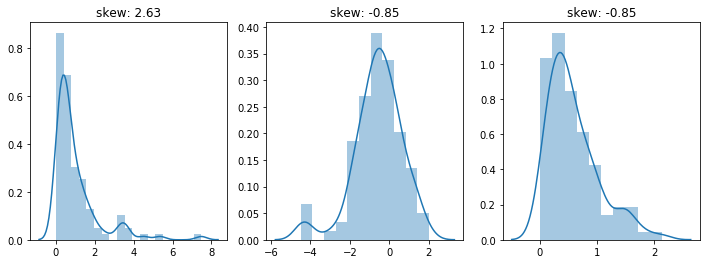

In [828]:
"""
- skewed data에 대해서 boxcolp 와 np.log의 차이는 
"""
from scipy.special import boxcox1p
from scipy.stats import skew
import numpy as np 

sample_size = 100
y_temp = np.random.exponential(1, sample_size)

f, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.distplot(y_temp, ax=axes[0])
axes[0].set_title("skew: {:.2f}".format(skew(y_temp)))

sns.distplot(np.log(y_temp), ax=axes[1])
axes[1].set_title("skew: {:.2f}".format(skew(np.log(y_temp))))

sns.distplot(np.log1p(y_temp), ax=axes[2])
axes[2].set_title("skew: {:.2f}".format(skew(np.log(y_temp))))
plt.show()

#pl.hist(h,normed=True)

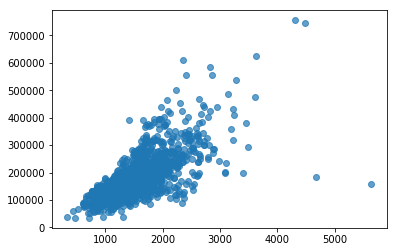

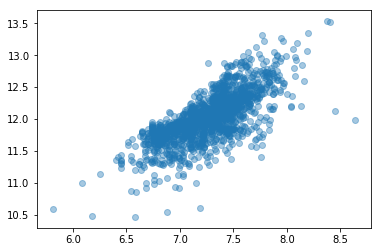

In [842]:
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=0.7)
plt.show()

plt.scatter(np.log(train_df['GrLivArea']), np.log(train_df['SalePrice']), alpha=0.4)
plt.show()

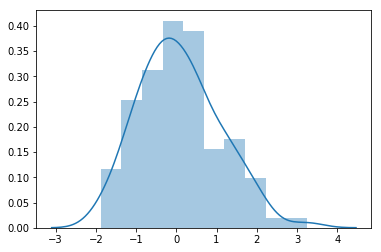

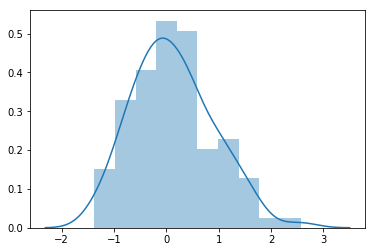

In [866]:
from sklearn.preprocessing import RobustScaler
import numpy as np 
import seaborn as sns 


scaler = RobustScaler()

x_temp = np.random.normal(0, 1, 100).reshape(-1, 1)


sns.distplot(x_temp)
plt.show()
sns.distplot(scaler.fit_transform(x_temp))
plt.legend()
plt.show()

(31, 1)
(31, 1)


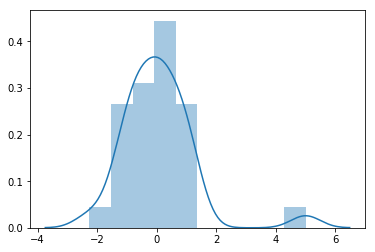

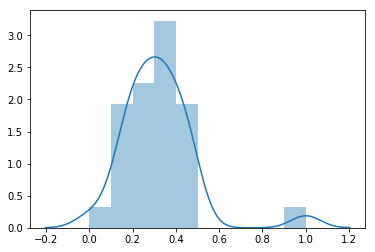

[-0.88161334] [ 0.1899706]
[-1.37414045] [ 0.12213862]
[ 0.9227529] [ 0.43847209]
[-0.66919528] [ 0.21922531]
[-2.26098747] [ 0.]
[-0.15214932] [ 0.29043407]
[ 0.94969829] [ 0.44218307]
[-0.87595202] [ 0.19075029]
[-0.84553439] [ 0.19493947]
[-0.0766877] [ 0.30082682]
[ 0.46922011] [ 0.37601051]
[ 0.2501401] [ 0.3458383]
[-0.24587825] [ 0.27752551]
[-0.43173735] [ 0.25192856]
[ 0.07097281] [ 0.32116297]
[ 1.2032771] [ 0.47710654]
[-0.69270417] [ 0.21598761]
[ 0.24497112] [ 0.34512642]
[ 1.22537998] [ 0.48015059]
[ 0.91835183] [ 0.43786597]
[ 0.49096487] [ 0.37900525]
[ 0.99481279] [ 0.44839635]
[ 0.64326074] [ 0.39997979]
[-0.56807501] [ 0.23315182]
[-1.2224158] [ 0.14303449]
[-1.25192042] [ 0.13897105]
[-0.57949962] [ 0.2315784]
[-0.05117888] [ 0.30433995]
[ 0.23020174] [ 0.34309234]
[ 0.13939205] [ 0.33058582]
[ 5.] [ 1.]


In [886]:
a = list(np.random.normal(0, 1, 30)) + [5]
a = np.array(a).reshape(-1, 1)
#a_scaled = MinMaxScaler().fit_transform(RobustScaler().fit_transform(a))
a_scaled = 


print(a.shape)
print(a_scaled.shape)

sns.distplot(a)
plt.show()

sns.distplot(a_scaled)
plt.show()

for i, j in zip(a, a_scaled):
    print(i, j)


In [871]:

a

[1.1334717308491671,
 -1.2689551197304436,
 -0.47819464970048542,
 -0.9874084570718612,
 -0.70475763475973829,
 -1.5543878453452535,
 0.13130192599664775,
 0.12842227086458197,
 -1.5356423969595507,
 1.627734583892771]